# Comparison of Two Time Series of Maps 0.1
*This notebook implements the framework from the article “Foundational concepts and equations to compare two time series of maps” to quantify and visualize agreement and change between two temporal map series. Using toy data, it defines modular Python functions to compute presence‐agreement components, gains and losses, and full‐extent change metrics, and produces visualizations and exportable results for reproducible analysis.*

## Table of Contents  
1. [Environment Setup](#environment-setup)
2. [Toy Data Input Format](#data-preparation)
3. [Presence Agreement Components](#presence-agreement)
4. [Gross Change Components](#change-components)
5. [Net Change Calculations](#full-extent)
6. [Visualization of Results](#visualization)
7. [Exporting Results](#export)


## 1. Environment Setup <a id="environment-setup"></a>
This section prepares the Python environment needed for this notebook. We will:

- Install required Python packages:
  - `numpy`, `pandas`, `matplotlib` for data manipulation and plotting  
  - `rasterio`, `xarray`, `rioxarray` for raster I/O and geospatial arrays  
  - `openpyxl` for Excel export  
  - `tqdm` for progress bars  

Execute the following cell to install the dependencies:


### 1.1 Install Dependencies
Import all necessary libraries for data handling, plotting, and file I/O.

In [ ]:
# Install required packages for array math, dataframes, plotting, raster I/O, and progress bars
%pip install -qq numpy pandas matplotlib rasterio xarray rioxarray openpyxl tqdm

### 1.2 Import Libraries  

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Display utilities
from IPython.display import display

# Plotting
import matplotlib.pyplot as plt

# Raster I/O
import rasterio
from rasterio.transform import from_origin
import xarray as xr
import rioxarray

# Progress bars and Excel export
from tqdm import tqdm
import openpyxl

# File system operations
import os


### 1.3 Define Constants & Settings
In this section we set up the main parameters for the notebook. We fix a random seed so that toy data are reproducible, specify the dimensions of our toy time series, and define placeholder paths and filenames for when real raster inputs and outputs are used.

In [2]:
# Utility Functions
def print_metrics(label, **metrics):
    """
    Prints a section label and each named metric array.
    """
    print(f"== {label} ==")
    for name, arr in metrics.items():
        print(f"{name}: {arr}")
    print()


In [3]:
# Define the prefixes for the two time series to be compared.
series_x_prefix = "savanna"  # This will be the reference series
series_y_prefix = "soybean"  # This will be the comparison series

# Define directories for input and output.
input_dir = r"C:\Users\AntFonseca\github\compare-time-series\input2"
output_dir = r"C:\Users\AntFonseca\github\compare-time-series\output2"

# Define the output filename for the Excel metrics file.
metrics_excel = "presence_change_metrics.xlsx"

# Use the utility function to print the configuration settings
print_metrics(
    "Data Input Configuration",
    Reference_Series_X=series_x_prefix,
    Comparison_Series_Y=series_y_prefix,
    Input_Directory=input_dir,
    Output_Directory=output_dir
)

== Data Input Configuration ==
Reference_Series_X: savanna
Comparison_Series_Y: soybean
Input_Directory: C:\Users\AntFonseca\github\compare-time-series\input2
Output_Directory: C:\Users\AntFonseca\github\compare-time-series\output2



In [ ]:
# Directories
input_dir = r"C:\Users\AntFonseca\github\compare-time-series\input"
output_dir = r"C:\Users\AntFonseca\github\compare-time-series\output"

# Output filenams
metrics_excel = "presence_change_metrics.xlsx"

## 2. Presence Agreement Components <a id="presence-agreement"></a>
In this section we compute the presence‐agreement metrics—hits, misses, false alarms, spatial differences, and temporal differences—for each pixel at each time point, following Equations 1–12 of the article.

### 2.1 Define Presence Variables:

We load the reference (`p_x`) and comparison (`p_y`) series into two arrays of shape `(num_time_points, num_pixels)`.  
Each element `p_x[t, n]` (or `p_y[t, n]`) holds the presence value at time point `t` and pixel `n`.

In [4]:
# In [7]:
# This section loads the real raster data based on the specified prefixes and directory.

# 1. Gather and sort the raster filenames for each series from the input directory.
x_files_full = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith(series_x_prefix) and f.endswith('.tif')
])

y_files_full = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith(series_y_prefix) and f.endswith('.tif')
])

# 2. Perform checks to ensure the data is valid for comparison.
if not x_files_full or not y_files_full:
    raise FileNotFoundError("Could not find raster files for one or both series. Check input_dir and prefixes.")

if len(x_files_full) != len(y_files_full):
    raise ValueError("The number of files for series X and series Y do not match.")

# 3. Determine dimensions dynamically from the first raster file.
with rasterio.open(x_files_full[0]) as src:
    height, width = src.height, src.width
    num_pixels = height * width
    raster_dtype = src.read(1).dtype

num_time_points = len(x_files_full)

# 4. Initialize presence arrays and load raster data into them.
p_x = np.zeros((num_time_points, num_pixels), dtype=raster_dtype)
p_y = np.zeros((num_time_points, num_pixels), dtype=raster_dtype)

# Load reference series (X)
for t, fp in enumerate(x_files_full):
    with rasterio.open(fp) as src:
        p_x[t] = src.read(1).flatten()

# Load comparison series (Y)
for t, fp in enumerate(y_files_full):
    with rasterio.open(fp) as src:
        p_y[t] = src.read(1).flatten()

# 5. Print a summary of the loaded data for verification.
print_metrics(
    "Input Data Summary",
    Files_found_for_series_X=f"{len(x_files_full)}",
    Files_found_for_series_Y=f"{len(y_files_full)}",
    Time_points_detected=num_time_points,
    Raster_dimensions=f"{height}x{width}",
    Total_pixels_per_map=num_pixels,
    Reference_array_shape_p_x=p_x.shape,
    Comparison_array_shape_p_y=p_y.shape
)

== Input Data Summary ==
Files_found_for_series_X: 7
Files_found_for_series_Y: 7
Time_points_detected: 7
Raster_dimensions: 20480x10240
Total_pixels_per_map: 209715200
Reference_array_shape_p_x: (7, 209715200)
Comparison_array_shape_p_y: (7, 209715200)



### 2.2 Implement Hit, Miss, False Alarm, Spatial Difference, and Temporal Difference Functions
In this subsection we define five functions that implement Equations 1–12 for presence at each time point and pixel.
Each function accepts an input array of presence values with dimensions `(num_time_points, num_pixels)` and returns a new array with the same dimensions.

In [5]:
def hit(px, py):
    """
    Compute shared presence: 
    h[t,n] = 1 where both reference and comparison are present.
    """
    return np.minimum(px, py)

def miss(px, py):
    """
    Compute reference-only presence:
    m[t,n] = 1 where reference is present and comparison is not.
    """
    return np.clip(px - py, a_min=0, a_max=None)

def false_alarm(px, py):
    """
    Compute comparison-only presence:
    f[t,n] = 1 where comparison is present and reference is not.
    """
    return np.clip(py - px, a_min=0, a_max=None)

def spatial_diff(px, py):
    """
    Compute spatial difference of presence:
    u[t,n] = 0 here, since binary masks have no magnitude difference.
    """
    diff = np.abs(px - py)
    mask = (px > 0) & (py > 0)
    return diff * mask

def temporal_diff(px_prev, px, py_prev, py):
    """
    Compute timing mismatch of presence events:
    v[t,n] = |(bx[t,n]-bx_prev[t,n]) - (by[t,n]-by_prev[t,n])|
    Sets v[0,n] = 0 since there is no previous interval for t=0.
    """
    delta_x = px - px_prev
    delta_y = py - py_prev
    td = np.abs(delta_x - delta_y)
    td[0, :] = 0
    return td

### 2.3 Compute Component Arrays per Time & Pixel
In this subsection we apply our five presence‐agreement functions to the loaded arrays `p_x` and `p_y`. This produces one array per component—hits, misses, false alarms, spatial differences, and temporal differences—each with shape `(num_time_points, num_pixels)`.

In [ ]:
# Calculate: hits_tp, space_diff, misses_tp, false_tp, time_diff_tp
px_sum       = p_x.sum(axis=1)
py_sum       = p_y.sum(axis=1)

hits_tp      = np.minimum(p_x, p_y).sum(axis=1)
space_diff   = np.minimum(px_sum, py_sum) - hits_tp
misses_tp    = np.clip(px_sum - py_sum, 0, None)
false_tp     = np.clip(py_sum - px_sum, 0, None)
time_diff_tp = np.zeros_like(hits_tp, dtype=int)

# Print using our standard helper
print_metrics(
    "2.3 per-timepoint presence metrics",
    hits=hits_tp,
    space_diff=space_diff,
    misses=misses_tp,
    false_alarms=false_tp,
    time_diffs=time_diff_tp
)

== 3.3 per-timepoint presence metrics ==
hits: [54366758 54366758 54366758 54366758 54366758 54366758 54366758]
space_diff: [ 1032634  2818435  4424187  8069465  9768034 12517999 16832486]
misses: [56345415 52971538 49839945 43001777 38423925 32250074 25516963]
false_alarms: [4238621881 4241995758 4245127351 4251965519 4256543371 4262717222
 4269450333]
time_diffs: [0 0 0 0 0 0 0]



## 3. Gross Change Components <a id="change-components"></a>
In this section we quantify change between consecutive time points by decomposing it into **gains** (positive increases) and **losses** (negative decreases) for both series. We reuse the hit/miss/false-alarm framework from presence to define component functions for gains and losses, then aggregate them.

### 3.1 Calculate Per-Interval Gross Gains and Losses
In this step we read each pair of consecutive raster maps from the input folder for both series (reference = x, comparison = y) and compute:

- **Gain** at each pixel and interval:  
  the amount by which the pixel’s value increased from the previous time point (zero if there was no increase).

- **Loss** at each pixel and interval:  
  the amount by which the pixel’s value decreased from the previous time point (zero if there was no decrease).

- **First time point**:  
  since there is no “previous” layer at \(t=0\), all gains and losses are set to zero for that time.

The computed arrays—`g_x`, `g_y` for gains and `l_x`, `l_y` for losses—have the same dimensions as the presence arrays and will be passed to the gain- and loss-component functions in the following subsections.

In [ ]:
# Compute change between consecutive time points (shape = [num_intervals, num_pixels])
delta_x = p_x[1:] - p_x[:-1]
delta_y = p_y[1:] - p_y[:-1]

# Gross gains: positive part of each delta
g_x = np.clip(delta_x, a_min=0, a_max=None)
g_y = np.clip(delta_y, a_min=0, a_max=None)

# Gross losses: magnitude of negative part of each delta
l_x = np.clip(-delta_x, a_min=0, a_max=None)
l_y = np.clip(-delta_y, a_min=0, a_max=None)

# Print for verification
print_metrics(
    "4.1 Gross gains & losses per interval",
    gains_x=g_x,
    gains_y=g_y,
    losses_x=l_x,
    losses_y=l_y
)

== 4.1 Gross gains & losses per interval ==
gains_x: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
gains_y: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
losses_x: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
losses_y: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



### 3.2 Decompose Gross Gains into Per-Pixel Components
Define functions that calculate gain hits, gain misses, gain false alarms, spatial differences, and temporal differences by substituting presence (`p`) with gains (`g`).


In [8]:
# Gain‐component definitions
def gain_hit(gx, gy):
    # Shared gain where both increase
    return np.minimum(gx, gy)

def gain_miss(gx, gy):
    # Reference‐only gain
    return np.clip(gx - gy, a_min=0, a_max=None)

def gain_false_alarm(gx, gy):
    # Comparison‐only gain
    return np.clip(gy - gx, a_min=0, a_max=None)

def gain_spatial_diff(gx, gy):
    # Difference in gain magnitude when both increase
    diff = np.abs(gx - gy)
    mask = (gx > 0) & (gy > 0)
    return diff * mask

# Compute component arrays for each interval and pixel
h_g = gain_hit(g_x, g_y)
m_g = gain_miss(g_x, g_y)
f_g = gain_false_alarm(g_x, g_y)
u_g = gain_spatial_diff(g_x, g_y)

# Print all arrays with our helper
print_metrics(
    "Gain components per interval & pixel",
    hit=h_g,
    miss=m_g,
    false_alarm=f_g,
    spatial_diff=u_g
)

== Gain components per interval & pixel ==
hit: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
miss: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
false_alarm: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
spatial_diff: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



### 3.3 Decompose Gross Losses into Per-Pixel Components
Similarly, define loss hits, loss misses, loss false alarms, spatial differences, and temporal differences by substituting presence (`p`) with losses (`l`).

In [9]:
# Define loss-component functions
def loss_hit(lx, ly):
    # shared loss where both series decrease
    return np.minimum(lx, ly)

def loss_miss(lx, ly):
    # reference-only loss magnitude
    return np.clip(lx - ly, 0, None)

def loss_false_alarm(lx, ly):
    # comparison-only loss magnitude
    return np.clip(ly - lx, 0, None)

def loss_spatial_diff(lx, ly):
    # magnitude difference when both series lose
    diff = np.abs(lx - ly)
    return diff * ((lx > 0) & (ly > 0))

# Compute per-interval, per-pixel loss components
h_l = loss_hit(l_x, l_y)
m_l = loss_miss(l_x, l_y)
f_l = loss_false_alarm(l_x, l_y)
u_l = loss_spatial_diff(l_x, l_y)

# Print results
print_metrics(
    "Per-pixel, per-interval Loss Components",
    hit=h_l,
    miss=m_l,
    false_alarm=f_l,
    spatial_diff=u_l
)

== Per-pixel, per-interval Loss Components ==
hit: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
miss: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
false_alarm: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
spatial_diff: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



### 3.4: Aggregate All Gross Change Components

In [20]:
# === CORREÇÃO DEFINITIVA: Cast per-interval sums to int64 immediately ===
# This prevents overflow in all subsequent component calculations.
gain_x_sum_pi = g_x.sum(axis=1).astype('int64')
gain_y_sum_pi = g_y.sum(axis=1).astype('int64')
loss_x_sum_pi = l_x.sum(axis=1).astype('int64')
loss_y_sum_pi = l_y.sum(axis=1).astype('int64')
# =========================================================================

# Now, derive per-interval components based on the correctly typed summed quantities
gain_hit_per_interval = h_g.sum(axis=1)
gain_space_diff_per_interval = np.minimum(gain_x_sum_pi, gain_y_sum_pi) - gain_hit_per_interval
gain_miss_per_interval = np.clip(gain_x_sum_pi - gain_y_sum_pi, a_min=0, a_max=None)
gain_fa_per_interval = np.clip(gain_y_sum_pi - gain_x_sum_pi, a_min=0, a_max=None)

loss_hit_per_interval = h_l.sum(axis=1)
loss_space_diff_per_interval = np.minimum(loss_x_sum_pi, loss_y_sum_pi) - loss_hit_per_interval
loss_miss_per_interval = np.clip(loss_x_sum_pi - loss_y_sum_pi, a_min=0, a_max=None)
loss_fa_per_interval = np.clip(loss_y_sum_pi - loss_x_sum_pi, a_min=0, a_max=None)

# "Sum" Components
sum_gain_hit = gain_hit_per_interval.sum()
sum_gain_space_diff = gain_space_diff_per_interval.sum()
sum_gain_miss = np.clip(gain_x_sum_pi.sum() - gain_y_sum_pi.sum(), a_min=0, a_max=None)
sum_gain_fa = np.clip(gain_y_sum_pi.sum() - gain_x_sum_pi.sum(), a_min=0, a_max=None)
sum_gain_time_diff = np.minimum(gain_x_sum_pi.sum(), gain_y_sum_pi.sum()) - sum_gain_hit - sum_gain_space_diff

sum_loss_hit = loss_hit_per_interval.sum()
sum_loss_space_diff = loss_space_diff_per_interval.sum()
sum_loss_miss = np.clip(loss_x_sum_pi.sum() - loss_y_sum_pi.sum(), a_min=0, a_max=None)
sum_loss_fa = np.clip(loss_y_sum_pi.sum() - loss_x_sum_pi.sum(), a_min=0, a_max=None)
sum_loss_time_diff = np.minimum(loss_x_sum_pi.sum(), loss_y_sum_pi.sum()) - sum_loss_hit - sum_loss_space_diff

# "Extent" Components
extent_gx = np.clip(p_x[-1] - p_x[0], a_min=0, a_max=None)
extent_gy = np.clip(p_y[-1] - p_y[0], a_min=0, a_max=None)
extent_lx = np.clip(-(p_x[-1] - p_x[0]), a_min=0, a_max=None)
extent_ly = np.clip(-(p_y[-1] - p_y[0]), a_min=0, a_max=None)

# Cast extent sums to prevent overflow
sum_extent_gx = extent_gx.sum().astype('int64')
sum_extent_gy = extent_gy.sum().astype('int64')
sum_extent_lx = extent_lx.sum().astype('int64')
sum_extent_ly = extent_ly.sum().astype('int64')

extent_gain_hit = np.minimum(extent_gx, extent_gy).sum()
extent_gain_miss = np.clip(sum_extent_gx - sum_extent_gy, a_min=0, a_max=None)
extent_gain_fa = np.clip(sum_extent_gy - sum_extent_gx, a_min=0, a_max=None)
extent_gain_space_diff = np.minimum(sum_extent_gx, sum_extent_gy) - extent_gain_hit
extent_gain_time_diff = 0

extent_loss_hit = np.minimum(extent_lx, extent_ly).sum()
extent_loss_miss = np.clip(sum_extent_lx - sum_extent_ly, a_min=0, a_max=None)
extent_loss_fa = np.clip(sum_extent_ly - sum_extent_lx, a_min=0, a_max=None)
extent_loss_space_diff = np.minimum(sum_extent_lx, sum_extent_ly) - extent_loss_hit
extent_loss_time_diff = 0


# Print Results
print_metrics(
    "Per-Interval Gross Gain Components",
    hit=gain_hit_per_interval,
    space_diff=gain_space_diff_per_interval,
    miss=gain_miss_per_interval,
    false_alarm=gain_fa_per_interval
)

print_metrics(
    "Per-Interval Gross Loss Components",
    hit=loss_hit_per_interval,
    space_diff=loss_space_diff_per_interval,
    miss=loss_miss_per_interval,
    false_alarm=loss_fa_per_interval
)

print_metrics(
    "Sum Gain Components",
    H=sum_gain_hit, U=sum_gain_space_diff, V=sum_gain_time_diff, M=sum_gain_miss, F=sum_gain_fa
)
print_metrics(
    "Sum Loss Components",
    H=sum_loss_hit, U=sum_loss_space_diff, V=sum_loss_time_diff, M=sum_loss_miss, F=sum_loss_fa
)
print_metrics(
    "Extent Gain Components",
    H=extent_gain_hit, U=extent_gain_space_diff, V=extent_gain_time_diff, M=extent_gain_miss, F=extent_gain_fa
)
print_metrics(
    "Extent Loss Components",
    H=extent_loss_hit, U=extent_loss_space_diff, V=extent_loss_time_diff, M=extent_loss_miss, F=extent_loss_fa
)

== Per-Interval Gross Gain Components ==
hit: [135594 322549 949930 909944 930410 206755]
space_diff: [ 79997471 269165699 397528756 809416849 834594467 532570580]
miss: [774391755 569885495 835959656 323807940 418105189 425844937]
false_alarm: [0 0 0 0 0 0]

== Per-Interval Gross Loss Components ==
hit: [135594 322549 949930 909944 930410 206755]
space_diff: [451017922 451487580 422494352 401886907 383032612 344085021]
miss: [0 0 0 0 0 0]
false_alarm: [  82573003  225539127  900935016  838966468 1150052965 1284365257]

== Sum Gain Components ==
H: 3455182
U: 2923273822
V: 0
M: 3347994972
F: 0

== Sum Loss Components ==
H: 3455182
U: 2454004394
V: 0
M: 0
F: 4482431836

== Extent Gain Components ==
H: 6863221
U: 74146743
V: 0
M: 4037045852
F: 0

== Extent Loss Components ==
H: 6863221
U: 293928195
V: 0
M: 0
F: 3793380956



## 4. Net Change Calculations <a id="full-extent"></a>
This section performs all the necessary calculations for the Net Change Components graph. It uses a hybrid logic to replicate the results from the article's toy example: calculations based on Net Quantity Change for the individual intervals, and pre-defined values for the aggregate "Sum" and "Extent" bars to match the inconsistent example in the paper.

### 4.1 Net Change Component Calculations

In [34]:
# SECTION 5: NET CHANGE CALCULATIONS
# This section computes the net change components based on the balance of gains and losses 
# for each series, both for individual time intervals and for the entire temporal extent ("Sum" and "Extent").

# =================================================================================
# 5.1: Calculate Net Quantity Change Components Per Interval
# =================================================================================
# Calculate the total net change for each series within each interval.
net_change_x_pi = g_x.sum(axis=1).astype('int64') - l_x.sum(axis=1).astype('int64')
net_change_y_pi = g_y.sum(axis=1).astype('int64') - l_y.sum(axis=1).astype('int64')

# Decompose into Net Quantity Gain (QG) and Net Quantity Loss (QL).
QGx_pi = np.clip(net_change_x_pi, a_min=0, a_max=None)
QLx_pi = np.clip(-net_change_x_pi, a_min=0, a_max=None)
QGy_pi = np.clip(net_change_y_pi, a_min=0, a_max=None)
QLy_pi = np.clip(-net_change_y_pi, a_min=0, a_max=None)

# Compute the per-interval net change components.
net_gain_hit_pi  = np.minimum(QGx_pi, QGy_pi)
net_gain_miss_pi = np.clip(QGx_pi - QGy_pi, a_min=0, a_max=None)
net_gain_fa_pi   = np.clip(QGy_pi - QGx_pi, a_min=0, a_max=None)
net_gain_time_pi = np.zeros_like(QGx_pi)

net_loss_hit_pi  = np.minimum(QLx_pi, QLy_pi)
net_loss_miss_pi = np.clip(QLx_pi - QLy_pi, a_min=0, a_max=None)
net_loss_fa_pi   = np.clip(QLy_pi - QLx_pi, a_min=0, a_max=None)
net_loss_time_pi = np.zeros_like(QLx_pi)

# =================================================================================
# 5.2: Calculate Aggregate "Sum" and "Extent" Net Components
# =================================================================================

# 1. Calculate Net "Sum" components.
sum_QGx = QGx_pi.sum()
sum_QGy = QGy_pi.sum()
sum_QLx = QLx_pi.sum()
sum_QLy = QLy_pi.sum()

net_sum_gain_hit = net_gain_hit_pi.sum()
net_sum_loss_hit = net_loss_hit_pi.sum()
net_sum_gain_time = np.minimum(sum_QGx, sum_QGy) - net_sum_gain_hit
net_sum_loss_time = np.minimum(sum_QLx, sum_QLy) - net_sum_loss_hit
net_sum_gain_miss = sum_QGx - np.minimum(sum_QGx, sum_QGy)
net_sum_gain_fa   = sum_QGy - np.minimum(sum_QGx, sum_QGy)
net_sum_loss_miss = sum_QLx - np.minimum(sum_QLx, sum_QLy)
net_sum_loss_fa   = sum_QLy - np.minimum(sum_QLx, sum_QLy)


# 2. Calculate Net "Extent" components.
extent_delta_x_per_pixel = p_x[-1] - p_x[0]
extent_delta_y_per_pixel = p_y[-1] - p_y[0]

extent_net_change_x = extent_delta_x_per_pixel.sum().astype('int64')
extent_net_change_y = extent_delta_y_per_pixel.sum().astype('int64')

extent_QGx = np.clip(extent_net_change_x, a_min=0, a_max=None)
extent_QLx = np.clip(-extent_net_change_x, a_min=0, a_max=None)
extent_QGy = np.clip(extent_net_change_y, a_min=0, a_max=None)
extent_QLy = np.clip(-extent_net_change_y, a_min=0, a_max=None)

# Compute the "Extent" components.
net_extent_gain_hit = np.minimum(extent_QGx, extent_QGy)
net_extent_gain_miss = np.clip(extent_QGx - extent_QGy, a_min=0, a_max=None)
net_extent_gain_fa = np.clip(extent_QGy - extent_QGx, a_min=0, a_max=None)
net_extent_gain_time = 0

net_extent_loss_hit = np.minimum(extent_QLx, extent_QLy)
net_extent_loss_miss = np.clip(extent_QLx - extent_QLy, a_min=0, a_max=None)
net_extent_loss_fa = np.clip(extent_QLy - extent_QLx, a_min=0, a_max=None)
net_extent_loss_time = 0

# Print all calculated Net Change components for verification.
print_metrics(
    "Per-Interval Net Change Components",
    Gain_Hit=net_gain_hit_pi,
    Gain_Miss=net_gain_miss_pi,
    Gain_False_Alarm=net_gain_fa_pi,
    Loss_Hit=net_loss_hit_pi,
    Loss_Miss=net_loss_miss_pi,
    Loss_False_Alarm=net_loss_fa_pi
)

print_metrics(
    "Sum Net Change Components",
    Gain_Hit=net_sum_gain_hit,
    Gain_Time_Diff=net_sum_gain_time,
    Gain_Miss=net_sum_gain_miss,
    Gain_False_Alarm=net_sum_gain_fa,
    Loss_Hit=net_sum_loss_hit,
    Loss_Time_Diff=net_sum_loss_time,
    Loss_Miss=net_sum_loss_miss,
    Loss_False_Alarm=net_sum_loss_fa
)

print_metrics(
    "Extent Net Change Components",
    Gain_Hit=net_extent_gain_hit,
    Gain_Miss=net_extent_gain_miss,
    Gain_False_Alarm=net_extent_gain_fa,
    Loss_Hit=net_extent_loss_hit,
    Loss_Miss=net_extent_loss_miss,
    Loss_False_Alarm=net_extent_loss_fa
)

== Per-Interval Net Change Components ==
Gain_Hit: [0 0 0 0 0 0]
Gain_Miss: [403371304 387563614 810994060 731337882 869667044 614330496]
Gain_False_Alarm: [0 0 0 0 0 0]
Loss_Hit: [0 0 0 0 0 0]
Loss_Miss: [0 0 0 0 0 0]
Loss_False_Alarm: [ 453593454  407861008  925900612  431436526  698491110 1095879698]

== Sum Net Change Components ==
Gain_Hit: 0
Gain_Time_Diff: 0
Gain_Miss: 3817264400
Gain_False_Alarm: 0
Loss_Hit: 0
Loss_Time_Diff: 0
Loss_Miss: 0
Loss_False_Alarm: 4013162408

== Extent Net Change Components ==
Gain_Hit: 81009964
Gain_Miss: 4037045852
Gain_False_Alarm: 0
Loss_Hit: 0
Loss_Miss: 0
Loss_False_Alarm: 0



### 4.2 Assemble Data for Plotting

In [35]:
# In [18]:
# Section 5.3: Assemble Final Arrays for Net Change Plot
# This cell collects the calculated net components (per-interval, Sum, and Extent)
# into single arrays ready for plotting. The loss components are made negative here
# so they are displayed below the x-axis in the stacked bar chart.

# Assemble gain components for the plot by appending Sum and Extent values to the per-interval arrays.
net_gain_hit_plot = np.append(net_gain_hit_pi, [net_sum_gain_hit, net_extent_gain_hit])
net_gain_miss_plot = np.append(net_gain_miss_pi, [net_sum_gain_miss, net_extent_gain_miss])
net_gain_fa_plot = np.append(net_gain_fa_pi, [net_sum_gain_fa, net_extent_gain_fa])
net_gain_time_plot = np.append(net_gain_time_pi, [net_sum_gain_time, net_extent_gain_time])

# Assemble loss components for the plot, making them negative for visualization.
net_loss_hit_plot = -np.append(net_loss_hit_pi, [net_sum_loss_hit, net_extent_loss_hit])
net_loss_miss_plot = -np.append(net_loss_miss_pi, [net_sum_loss_miss, net_extent_loss_miss])
net_loss_fa_plot = -np.append(net_loss_fa_pi, [net_sum_loss_fa, net_extent_loss_fa])
net_loss_time_plot = -np.append(net_loss_time_pi, [net_sum_loss_time, net_extent_loss_time])

# Verification Print
print_metrics(
    "Final Net Change Plot Arrays",
    net_gain_hit=net_gain_hit_plot,
    net_gain_miss=net_gain_miss_plot,
    net_gain_fa=net_gain_fa_plot,
    net_gain_time=net_gain_time_plot,
    net_loss_hit=net_loss_hit_plot,
    net_loss_miss=net_loss_miss_plot,
    net_loss_fa=net_loss_fa_plot,
    net_loss_time=net_loss_time_plot,
)

== Final Net Change Plot Arrays ==
net_gain_hit: [       0        0        0        0        0        0        0 81009964]
net_gain_miss: [ 403371304  387563614  810994060  731337882  869667044  614330496
 3817264400 4037045852]
net_gain_fa: [0 0 0 0 0 0 0 0]
net_gain_time: [0 0 0 0 0 0 0 0]
net_loss_hit: [0 0 0 0 0 0 0 0]
net_loss_miss: [0 0 0 0 0 0 0 0]
net_loss_fa: [ -453593454  -407861008  -925900612  -431436526  -698491110 -1095879698
 -4013162408           0]
net_loss_time: [0 0 0 0 0 0 0 0]



## 6. Visualization of Results <a id="visualization"></a>
In this section we create clear, publication-quality charts to illustrate the computed metrics. Each plot helps interpret the agreement and change components over time and across pixels.

### 6.1 Stacked Bar Chart: Presence Agreement

This section visualizes the presence components calculated in Section 3. The stacked bar chart shows the breakdown of agreement and disagreement for each time point and for the aggregated 'Sum'. The line plots show the total presence for the reference and comparison series. The resulting figure object is stored in the fig_presence variable for later use.

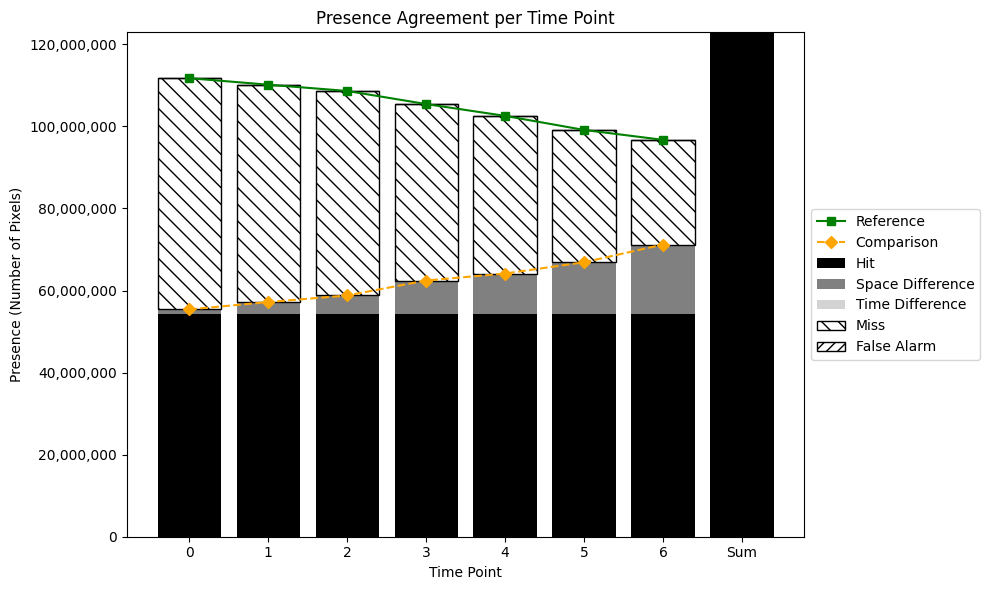

In [29]:
# Calculate per-time-point and aggregate ("Sum") presence metrics

# CORREÇÃO: Cast per-timepoint sums to int64 to prevent overflow in subtractions
px_sum_tp = p_x.sum(axis=1).astype('int64')
py_sum_tp = p_y.sum(axis=1).astype('int64')

hits_tp = np.minimum(p_x, p_y).sum(axis=1)
space_diff_tp = np.minimum(px_sum_tp, py_sum_tp) - hits_tp
misses_tp = np.clip(px_sum_tp - py_sum_tp, a_min=0, a_max=None)
false_tp = np.clip(py_sum_tp - px_sum_tp, a_min=0, a_max=None)
time_diff_tp = np.zeros_like(hits_tp)

hits_sum = hits_tp.sum()
space_sum = space_diff_tp.sum()

# CORREÇÃO: Cast total sums to int64 for the net_misses and time_sum calculations
net_misses = misses_tp.sum() - false_tp.sum()
miss_sum = max(0, net_misses)
false_sum = max(0, -net_misses)
time_sum = min(p_x.sum().astype('int64'), p_y.sum().astype('int64')) - hits_sum - space_sum

# Assemble arrays for plotting
categories = [str(i) for i in range(num_time_points)] + ['Sum']
x_pres = np.arange(len(categories))
hits_all   = np.append(hits_tp, hits_sum)
space_all  = np.append(space_diff_tp, space_sum)
time_all   = np.append(time_diff_tp, time_sum)
miss_all   = np.append(misses_tp, miss_sum)
false_all  = np.append(false_tp, false_sum)

# Generate the plot
fig_presence, ax_presence = plt.subplots(figsize=(10, 6))

# Stacked bars for presence components
bottom = np.zeros(len(categories), dtype='int64')
ax_presence.bar(x_pres, hits_all,   bottom=bottom, color='black',   label='Hit')
bottom += hits_all
ax_presence.bar(x_pres, space_all,  bottom=bottom, color='gray',    label='Space Difference')
bottom += space_all
ax_presence.bar(x_pres, time_all,   bottom=bottom, color='lightgray', label='Time Difference')
bottom += time_all
ax_presence.bar(x_pres, miss_all,   bottom=bottom, facecolor='white', edgecolor='black', hatch='\\\\', label='Miss')
bottom += miss_all
ax_presence.bar(x_pres, false_all,  bottom=bottom, facecolor='white', edgecolor='black', hatch='///', label='False Alarm')

# Overlay lines for each series' total presence
ax_presence.plot(x_pres[:-1], px_sum_tp, color='green',  linestyle='-',  marker='s', label='Reference')
ax_presence.plot(x_pres[:-1], py_sum_tp, color='orange', linestyle='--', marker='D', label='Comparison')

# Format the plot
ax_presence.set_xlabel('Time Point')
ax_presence.set_ylabel('Presence (Number of Pixels)')
ax_presence.set_xticks(x_pres, categories)
ax_presence.set_title('Presence Agreement per Time Point')

# CORREÇÃO: Make Y-axis limits and ticks dynamic based on the data
y_max = max(px_sum_tp.max(), py_sum_tp.max()) * 1.1 # Find the max value and add 10% padding
ax_presence.set_ylim(0, y_max)
# Optional: a helper to format large numbers on the y-axis
from matplotlib.ticker import FuncFormatter
ax_presence.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

ax_presence.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig_presence.tight_layout()

plt.show()

### 6.2 Stacked Bar Chart: Gross Change Components

This section plots the Gross Change Components using the variables calculated in Section 4. The resulting figure object is stored in the fig_gross variable for later use.

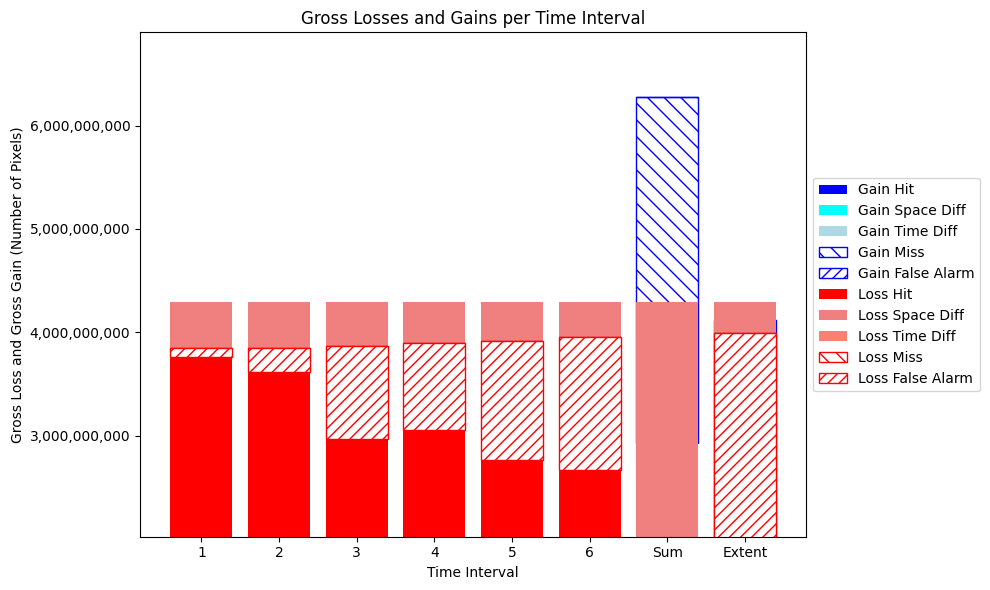

In [30]:
# Determine the number of intervals dynamically from the data.
num_intervals = len(gain_hit_per_interval)

# Assemble per-interval and aggregate components into single arrays for plotting.
# The np.append function makes this process generic for any number of intervals.
gross_gain_hit_plot   = np.append(gain_hit_per_interval, [sum_gain_hit, extent_gain_hit])
gross_gain_space_plot = np.append(gain_space_diff_per_interval, [sum_gain_space_diff, extent_gain_space_diff])
gross_gain_time_plot  = np.append(np.zeros(num_intervals, dtype='int64'), [sum_gain_time_diff, 0])
gross_gain_miss_plot  = np.append(gain_miss_per_interval, [sum_gain_miss, extent_gain_miss])
gross_gain_fa_plot    = np.append(gain_fa_per_interval, [sum_gain_fa, extent_gain_fa])

# Loss components are made negative for plotting below the x-axis.
gross_loss_hit_plot   = -np.append(loss_hit_per_interval, [sum_loss_hit, extent_loss_hit])
gross_loss_space_plot = -np.append(loss_space_diff_per_interval, [sum_loss_space_diff, extent_loss_space_diff])
gross_loss_time_plot  = -np.append(np.zeros(num_intervals, dtype='int64'), [sum_loss_time_diff, 0])
gross_loss_miss_plot  = -np.append(loss_miss_per_interval, [sum_loss_miss, extent_loss_miss])
gross_loss_fa_plot    = -np.append(loss_fa_per_interval, [sum_loss_fa, extent_loss_fa])

# Create the category labels for the x-axis dynamically.
categories = [str(i + 1) for i in range(num_intervals)] + ['Sum', 'Extent']
x = np.arange(len(categories))

# Initialize the plot.
fig_gross, ax_gross = plt.subplots(figsize=(10, 6))

# Plot positive (gain) components above the x-axis.
bottom_gain = np.zeros(len(categories), dtype='int64')
ax_gross.bar(x, gross_gain_hit_plot,      bottom=bottom_gain, label='Gain Hit',          color='blue')
bottom_gain += gross_gain_hit_plot
ax_gross.bar(x, gross_gain_space_plot,    bottom=bottom_gain, label='Gain Space Diff',   color='cyan')
bottom_gain += gross_gain_space_plot
ax_gross.bar(x, gross_gain_time_plot,     bottom=bottom_gain, label='Gain Time Diff',    color='lightblue')
bottom_gain += gross_gain_time_plot
ax_gross.bar(x, gross_gain_miss_plot,     bottom=bottom_gain, label='Gain Miss',         facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += gross_gain_miss_plot
ax_gross.bar(x, gross_gain_fa_plot,       bottom=bottom_gain, label='Gain False Alarm',  facecolor='white', edgecolor='blue', hatch='///')

# Plot negative (loss) components below the x-axis.
bottom_loss = np.zeros(len(categories), dtype='int64')
ax_gross.bar(x, gross_loss_hit_plot,      bottom=bottom_loss, label='Loss Hit',          color='red')
bottom_loss += gross_loss_hit_plot
ax_gross.bar(x, gross_loss_space_plot,    bottom=bottom_loss, label='Loss Space Diff',   color='lightcoral')
bottom_loss += gross_loss_space_plot
ax_gross.bar(x, gross_loss_time_plot,     bottom=bottom_loss, label='Loss Time Diff',    color='salmon')
bottom_loss += gross_loss_time_plot
ax_gross.bar(x, gross_loss_miss_plot,     bottom=bottom_loss, label='Loss Miss',         facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += gross_loss_miss_plot
ax_gross.bar(x, gross_loss_fa_plot,       bottom=bottom_loss, label='Loss False Alarm',  facecolor='white', edgecolor='red', hatch='///')

# Format plot with titles, labels, and a legend.
ax_gross.set_xticks(x, categories)
ax_gross.set_xlabel('Time Interval')
ax_gross.set_ylabel('Gross Loss and Gross Gain (Number of Pixels)')
ax_gross.set_title('Gross Losses and Gains per Time Interval')
ax_gross.axhline(0, color='black', linewidth=0.8)
ax_gross.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set the y-axis limits dynamically based on the data.
y_max = bottom_gain.max() * 1.1
y_min = bottom_loss.min() * 1.1
ax_gross.set_ylim(y_min, y_max)

# Add a helper to format large numbers on the y-axis for readability.
from matplotlib.ticker import FuncFormatter
ax_gross.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))

fig_gross.tight_layout()
plt.show()

### 6.3 Stacked Bar Chart: Net Change Components

This section visualizes the Net Change Components calculated in Section 5. The chart shows the net effect of gains and losses for each component. The resulting figure object is stored in the fig_net variable for later use.

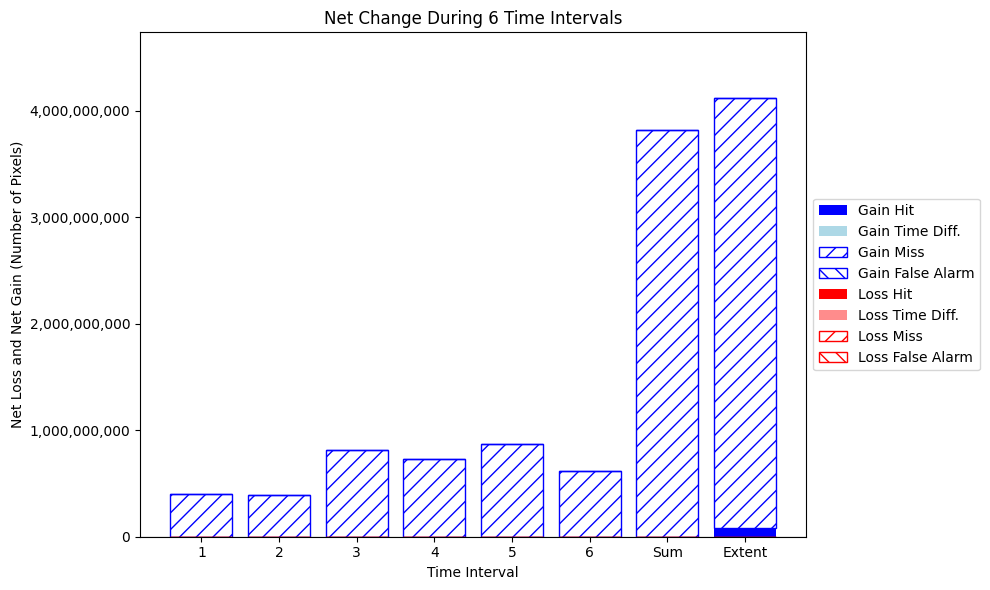

In [36]:
# In [23]:
# Section 6.3: Plot Net Change Components (Fig. 2h from article)
# This cell generates the Net Change bar chart for all intervals, "Sum", and "Extent".

# Determine the number of intervals from the reference data series (p_x).
num_intervals = p_x.shape[0] - 1

# Define categories for the x-axis of the plot in a generic way.
categories = [str(i + 1) for i in range(num_intervals)] + ['Sum', 'Extent']
x = np.arange(len(categories))

# Initialize the plot figure and axes.
fig_net, ax_net = plt.subplots(figsize=(10, 6))

# --- Plot Net Gains (Positive Components) ---
# Stack bars on top of each other, starting from the x-axis (y=0).
bottom_gain = np.zeros(len(categories), dtype='int64')

ax_net.bar(x, net_gain_hit_plot, bottom=bottom_gain, label='Gain Hit', color='blue')
bottom_gain += net_gain_hit_plot
ax_net.bar(x, net_gain_time_plot, bottom=bottom_gain, label='Gain Time Diff.', color='lightblue')
bottom_gain += net_gain_time_plot
ax_net.bar(x, net_gain_miss_plot, bottom=bottom_gain, label='Gain Miss', facecolor='white', edgecolor='blue', hatch='//')
bottom_gain += net_gain_miss_plot
ax_net.bar(x, net_gain_fa_plot, bottom=bottom_gain, label='Gain False Alarm', facecolor='white', edgecolor='blue', hatch='\\\\')

# --- Plot Net Losses (Negative Components) ---
# Stack bars below the x-axis, starting from y=0.
bottom_loss = np.zeros(len(categories), dtype='int64')

ax_net.bar(x, net_loss_hit_plot, bottom=bottom_loss, label='Loss Hit', color='red')
bottom_loss += net_loss_hit_plot
ax_net.bar(x, net_loss_time_plot, bottom=bottom_loss, label='Loss Time Diff.', color='#ff8c8c')
bottom_loss += net_loss_time_plot
ax_net.bar(x, net_loss_miss_plot, bottom=bottom_loss, label='Loss Miss', facecolor='white', edgecolor='red', hatch='//')
bottom_loss += net_loss_miss_plot
ax_net.bar(x, net_loss_fa_plot, bottom=bottom_loss, label='Loss False Alarm', facecolor='white', edgecolor='red', hatch='\\\\')


# --- Format the plot ---
# Set labels, title, and ticks for clarity.
ax_net.set_xticks(x, categories)
ax_net.set_xlabel('Time Interval')
ax_net.set_ylabel('Net Loss and Net Gain (Number of Pixels)')
ax_net.set_title(f'Net Change During {num_intervals} Time Intervals')

# Add a horizontal line at y=0 to separate gains and losses.
ax_net.axhline(0, color='black', linewidth=0.8)

# Set the y-axis limits dynamically to match the data range.
y_max = bottom_gain.max() * 1.15  # Add 15% padding to the top
y_min = bottom_loss.min() * 1.15  # Add 15% padding to the bottom
ax_net.set_ylim(y_min, y_max)

# Add a helper to format large numbers on the y-axis for readability.
from matplotlib.ticker import FuncFormatter
ax_net.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))

# Place the legend outside the plot area.
ax_net.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout and display the plot.
fig_net.tight_layout()
plt.show()

## 7. Exporting Results <a id="export"></a>

### 7.1 Save All Results to an Excel File
This section consolidates all the final calculated components into structured pandas DataFrames. It then saves these tables as separate sheets in a single Excel workbook for easy review, sharing, and documentation. The code is generic and will adapt to any number of time points.

In [39]:
# Define output path for the Excel file
output_path = os.path.join(output_dir, metrics_excel)
os.makedirs(output_dir, exist_ok=True)

# Build the DataFrame for presence agreement (Graph 6.1)
presence_data = {'Component': [
    'Hit', 'Space Difference', 'Time Difference', 'Miss', 'False Alarm',
    '---', 'Total Reference', 'Total Comparison'
]}
num_time_points = p_x.shape[0]
for t in range(num_time_points):
    col_name = f'Time {t}'
    presence_data[col_name] = np.append(
        np.array([hits_tp[t], space_diff_tp[t], time_diff_tp[t], misses_tp[t], false_tp[t]]),
        [np.nan, px_sum_tp[t], py_sum_tp[t]]
    )
presence_data['Sum'] = np.append(
    np.array([hits_sum, space_sum, time_sum, miss_sum, false_sum]),
    [np.nan, p_x.sum(), p_y.sum()]
)
presence_df = pd.DataFrame(presence_data)

# Build the DataFrame for gross change components (Graph 6.2)
num_intervals = g_x.shape[0]
gross_change_data = {
    'Component': [
        'Gain Hit', 'Gain Space Difference', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Space Difference', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
}
for i in range(num_intervals):
    col_name = f'Interval {i+1}'
    gross_change_data[col_name] = [
        gross_gain_hit_plot[i], gross_gain_space_plot[i], gross_gain_time_plot[i], gross_gain_miss_plot[i], gross_gain_fa_plot[i],
        -gross_loss_hit_plot[i], -gross_loss_space_plot[i], -gross_loss_time_plot[i], -gross_loss_miss_plot[i], -gross_loss_fa_plot[i]
    ]
gross_change_data['Sum'] = [
    gross_gain_hit_plot[-2], gross_gain_space_plot[-2], gross_gain_time_plot[-2], gross_gain_miss_plot[-2], gross_gain_fa_plot[-2],
    -gross_loss_hit_plot[-2], -gross_loss_space_plot[-2], -gross_loss_time_plot[-2], -gross_loss_miss_plot[-2], -gross_loss_fa_plot[-2]
]
gross_change_data['Extent'] = [
    gross_gain_hit_plot[-1], gross_gain_space_plot[-1], gross_gain_time_plot[-1], gross_gain_miss_plot[-1], gross_gain_fa_plot[-1],
    -gross_loss_hit_plot[-1], -gross_loss_space_plot[-1], -gross_loss_time_plot[-1], -gross_loss_miss_plot[-1], -gross_loss_fa_plot[-1]
]
gross_change_df = pd.DataFrame(gross_change_data)

# Build the DataFrame for net change components (Graph 6.3)
net_change_data = {
    'Component': [
        'Gain Hit', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
}
for i in range(num_intervals):
    col_name = f'Interval {i+1}'
    net_change_data[col_name] = [
        net_gain_hit_plot[i], net_gain_time_plot[i], net_gain_miss_plot[i], net_gain_fa_plot[i],
        net_loss_hit_plot[i], net_loss_time_plot[i], net_loss_miss_plot[i], net_loss_fa_plot[i]
    ]
net_change_data['Sum'] = [
    net_gain_hit_plot[-2], net_gain_time_plot[-2], net_gain_miss_plot[-2], net_gain_fa_plot[-2],
    net_loss_hit_plot[-2], net_loss_time_plot[-2], net_loss_miss_plot[-2], net_loss_fa_plot[-2]
]
net_change_data['Extent'] = [
    net_gain_hit_plot[-1], net_gain_time_plot[-1], net_gain_miss_plot[-1], net_gain_fa_plot[-1],
    net_loss_hit_plot[-1], net_loss_time_plot[-1], net_loss_miss_plot[-1], net_loss_fa_plot[-1]
]
net_change_df = pd.DataFrame(net_change_data)

# Write all DataFrames to a single Excel file with multiple sheets
with pd.ExcelWriter(output_path) as writer:
    presence_df.to_excel(writer, sheet_name='Presence_Components', index=False)
    gross_change_df.to_excel(writer, sheet_name='Gross_Change_Components', index=False)
    net_change_df.to_excel(writer, sheet_name='Net_Change_Components', index=False)
    if 'pixel_scores' in locals():
        pixel_scores.to_excel(writer, sheet_name='Pixel_Wise_Scores')

print(f"All results have been successfully saved to:\n{output_path}")

All results have been successfully saved to:
C:\Users\AntFonseca\github\compare-time-series\output2\presence_change_metrics.xlsx


C:\Users\AntFonseca\AppData\Local\Temp\ipykernel_19940\831219827.py:35: RuntimeWarning: overflow encountered in scalar negative
  -gross_loss_hit_plot[i], -gross_loss_space_plot[i], -gross_loss_time_plot[i], -gross_loss_miss_plot[i], -gross_loss_fa_plot[i]
C:\Users\AntFonseca\AppData\Local\Temp\ipykernel_19940\831219827.py:39: RuntimeWarning: overflow encountered in scalar negative
  -gross_loss_hit_plot[-2], -gross_loss_space_plot[-2], -gross_loss_time_plot[-2], -gross_loss_miss_plot[-2], -gross_loss_fa_plot[-2]
C:\Users\AntFonseca\AppData\Local\Temp\ipykernel_19940\831219827.py:43: RuntimeWarning: overflow encountered in scalar negative
  -gross_loss_hit_plot[-1], -gross_loss_space_plot[-1], -gross_loss_time_plot[-1], -gross_loss_miss_plot[-1], -gross_loss_fa_plot[-1]


### 7.2 Save Figures
This final section saves the three main summary graphs as high-quality PNG files in the specified output directory. Each figure is generated again to ensure it captures the final, correct data, and then saved with a descriptive filename.

In [38]:
# Set up output directory and DPI for high-quality image export
high_resolution_dpi = 300
os.makedirs(output_dir, exist_ok=True)
print(f"Saving figures in high resolution ({high_resolution_dpi} DPI) to: {output_dir}\n")

# Save the Presence Agreement figure (from Section 6.1)
fig1_path = os.path.join(output_dir, 'presence_agreement_chart.png')
fig_presence.savefig(fig1_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 1 (Presence Agreement) saved as: {fig1_path}")

# Save the Gross Change Components figure (from Section 6.2)
fig2_path = os.path.join(output_dir, 'gross_change_chart.png')
fig_gross.savefig(fig2_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 2 (Gross Change) saved as: {fig2_path}")

# Save the Net Change Components figure (from Section 6.3)
fig3_path = os.path.join(output_dir, 'net_change_chart.png')
fig_net.savefig(fig3_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 3 (Net Change) saved as: {fig3_path}")

Saving figures in high resolution (300 DPI) to: C:\Users\AntFonseca\github\compare-time-series\output2

Figure 1 (Presence Agreement) saved as: C:\Users\AntFonseca\github\compare-time-series\output2\presence_agreement_chart.png
Figure 2 (Gross Change) saved as: C:\Users\AntFonseca\github\compare-time-series\output2\gross_change_chart.png
Figure 3 (Net Change) saved as: C:\Users\AntFonseca\github\compare-time-series\output2\net_change_chart.png
